In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import seaborn as sns

import covid19

PALETTE = sns.color_palette()

## data

In [3]:
data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
data_italy_path = covid19.data.download('andamento-nazionale')

In [4]:
data_italy = pd.read_csv(data_italy_path, parse_dates=['data'], index_col=['data'])
data_italy.index = data_italy.index.normalize()

for column in ['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']:
    data_italy['variazione_' + column] = data_italy[column].diff(1)

data_italy.tail()

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,variazione_ricoverati_con_sintomi,variazione_terapia_intensiva,variazione_deceduti
data,,,,,,,,,,,,,,,,,
2020-03-31,ITA,28192,4023,32215,45420,77635,2107,4053,15729,12428,105792,506968,NaN,NaN,397.0,42.0,837.0
2020-04-01,ITA,28403,4035,32438,48134,80572,2937,4782,16847,13155,110574,541423,NaN,NaN,211.0,12.0,727.0
2020-04-02,ITA,28540,4053,32593,50456,83049,2477,4668,18278,13915,115242,581232,NaN,NaN,137.0,18.0,760.0
2020-04-03,ITA,28741,4068,32809,52579,85388,2339,4585,19758,14681,119827,619849,NaN,NaN,201.0,15.0,766.0
2020-04-04,ITA,29010,3994,33004,55270,88274,2886,4805,20996,15362,124632,657224,NaN,NaN,269.0,-74.0,681.0


## situation report

In [5]:
DAY = np.timedelta64(24 * 60 * 60, 's')

START_FIT = '2020-02-23'
STOP_FIT = '2020-04-01'

SHOWUNTIL = np.datetime64(data_italy.index.max(), 's') + 3 * DAY

EXTRAPOLATE = (np.datetime64('2020-02-23'), SHOWUNTIL)

In [6]:
fits = {}
fits['dimessi_guariti'] = covid19.fit.ExponentialFit.from_frame(data_italy['dimessi_guariti'], start='2020-03-08', stop=STOP_FIT)
fits['totale_casi_1'] = covid19.fit.ExponentialFit.from_frame(data_italy['totale_casi'], start=START_FIT, stop='2020-02-29')
fits['totale_casi'] = covid19.fit.ExponentialFit.from_frame(data_italy['totale_casi'], start='2020-03-01', stop='2020-03-09')

fits['ricoverati_con_sintomi_1'] = covid19.fit.ExponentialFit.from_frame(data_italy['ricoverati_con_sintomi'], start=START_FIT, stop='2020-03-06')
fits['ricoverati_con_sintomi_2'] = covid19.fit.ExponentialFit.from_frame(data_italy['ricoverati_con_sintomi'], start='2020-03-08', stop='2020-03-19')
fits['terapia_intensiva_1'] = covid19.fit.ExponentialFit.from_frame(data_italy['terapia_intensiva'], start=START_FIT, stop='2020-03-06')
fits['terapia_intensiva_2'] = covid19.fit.ExponentialFit.from_frame(data_italy['terapia_intensiva'], start='2020-03-07', stop='2020-03-13')
fits['terapia_intensiva_3'] = covid19.fit.ExponentialFit.from_frame(data_italy['terapia_intensiva'], start='2020-03-14', stop='2020-03-18')
fits['terapia_intensiva_4'] = covid19.fit.ExponentialFit.from_frame(data_italy['terapia_intensiva'], start='2020-03-19', stop='2020-03-24')
fits['deceduti_1'] = covid19.fit.ExponentialFit.from_frame(data_italy['deceduti'], start=START_FIT, stop='2020-03-11')
fits['deceduti_2'] = covid19.fit.ExponentialFit.from_frame(data_italy['deceduti'], start='2020-03-12', stop='2020-03-21')

fits['ricoverati_con_sintomi'] = covid19.fit.ExponentialFit.from_frame(data_italy['ricoverati_con_sintomi'], start='2020-03-27', stop=STOP_FIT)
fits['terapia_intensiva'] = covid19.fit.ExponentialFit.from_frame(data_italy['terapia_intensiva'], start='2020-03-25', stop=STOP_FIT)
fits['deceduti'] = covid19.fit.ExponentialFit.from_frame(data_italy['deceduti'], start='2020-03-27', stop=STOP_FIT)


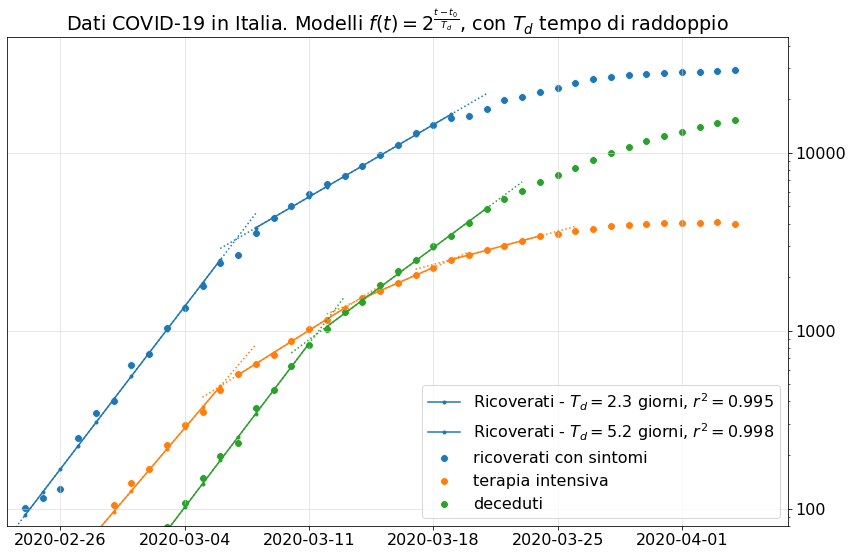

In [7]:
_, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (80, 45000)})
# _ = covid19.plot.add_events(ax, linestyle=':', offset=11, color='grey')

#ax.axvline(np.datetime64('2020-03-06'), linestyle=':', color=PALETTE[0])
#ax.axvline(np.datetime64('2020-03-11'), linestyle=':', color=PALETTE[1])

#ax.axvline(np.datetime64('2020-03-19'), linestyle=':', color=PALETTE[0])
#ax.axvline(np.datetime64('2020-03-22'), linestyle=':', color=PALETTE[1])

covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_1'], label='Ricoverati', color=PALETTE[0])
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_2'], label='Ricoverati', color=PALETTE[0])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_1'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_2'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_3'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_4'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['deceduti_1'], color=sns.color_palette()[2])
covid19.plot.plot_fit(ax, fits['deceduti_2'], color=sns.color_palette()[2])
for kind, color in zip(['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti'], sns.color_palette()):
    covid19.plot.plot_data(ax, data_italy[kind], label=kind.replace('_', ' '), color=color, date_interval=7)

_ = ax.set(title=r'Dati COVID-19 in Italia. Modelli $f(t) = 2 ^ \frac{t - t_0}{T_d}$, con $T_d$ tempo di raddoppio')
_ = ax.yaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.xaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.yaxis.tick_right()
_ = ax.set(xlim=EXTRAPOLATE)
#_ = ax.legend(loc='upper left')


No handles with labels found to put in legend.


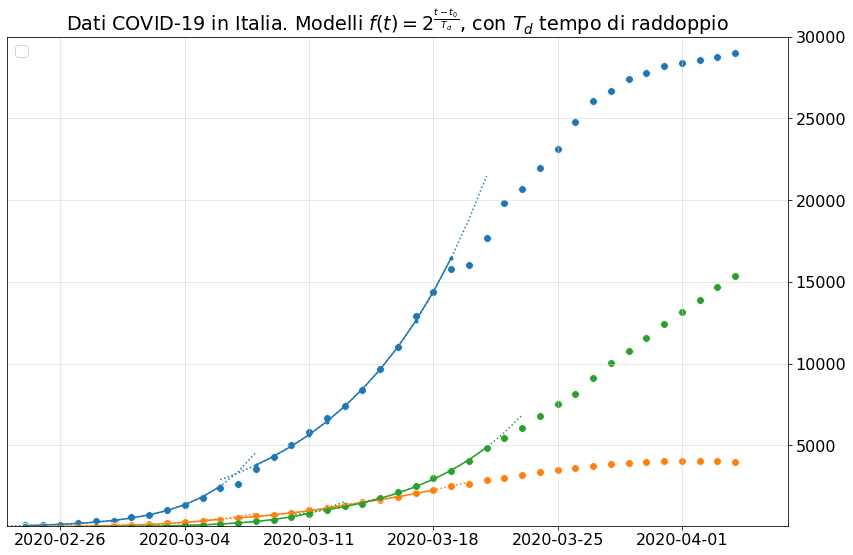

In [8]:
_, ax = plt.subplots(subplot_kw={'yscale': 'linear', 'ylim': (80, 30000)})
# _ = covid19.plot.add_events(ax, linestyle=':', offset=17, color='grey')

covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_1'], color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_2'], color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_1'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_2'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_3'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['deceduti_1'], color=sns.color_palette()[2])
covid19.plot.plot_fit(ax, fits['deceduti_2'], color=sns.color_palette()[2])
for kind, color in zip(['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti'], sns.color_palette()):
    covid19.plot.plot_data(ax, data_italy[kind], color=color, date_interval=7)

_ = ax.set(title=r'Dati COVID-19 in Italia. Modelli $f(t) = 2 ^ \frac{t - t_0}{T_d}$, con $T_d$ tempo di raddoppio')
_ = ax.yaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.xaxis.grid(color='lightgrey', linewidth=0.5)
_ = ax.yaxis.tick_right()
_ = ax.set(xlim=EXTRAPOLATE)
_ = ax.legend(loc='upper left')


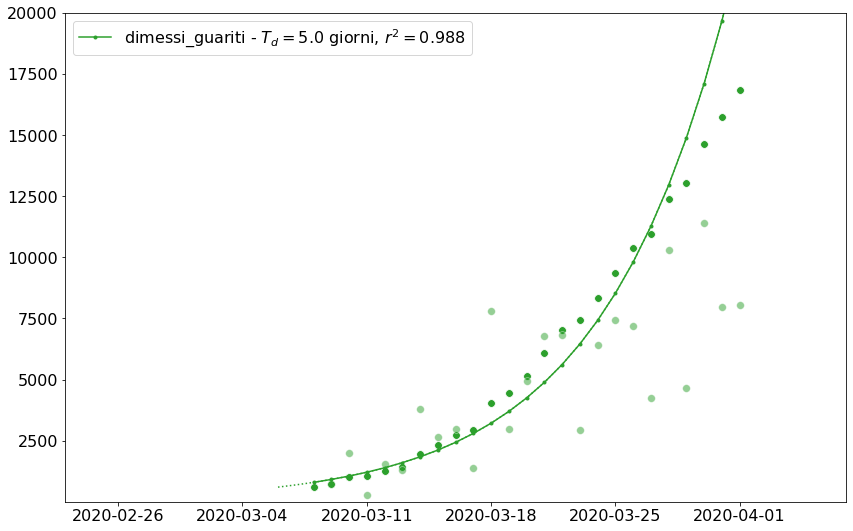

In [9]:
_, ax = plt.subplots(subplot_kw={'ylim': (5, 20000), 'xlim': EXTRAPOLATE})
kind = 'dimessi_guariti'
covid19.plot.plot(ax, data_italy[kind], fits['dimessi_guariti'], label=kind, color=color)
